In [13]:
from NNnet_Support import nn_support
from sklearn.model_selection import train_test_split,KFold,LearningCurveDisplay
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
from mlrose_hiive import NeuralNetwork,GeomDecay,ExpDecay
import numpy as np

In [11]:
DEFAULT_DICT={
    'max_attempts':10,
    'max_iters':10000,
    'learning_rate':0.0001,
    'clip_max':1000,
    'nodes':100,
    'layers':2,
    'activation':'relu',
    'curve':True,
    'early_stopping':True
}


ALGO_DICTS = {
        'random_hill_climb':{
            'restarts':np.arange(0,50,5)
        },
        
        'simulated_annealing':{
            'schedule': [
            GeomDecay(5),
            GeomDecay(10),
            GeomDecay(50),
            ExpDecay(5),
            ExpDecay(10),
            ExpDecay(50)]   
        },

        'genetic_alg':{
            'pop_size':[250,500,1000],
            'pop_breed_percent':[0.1,0.25,0.5],
            'mutation_prob':[0.1,0.25,0.35]
        },

}

In [ ]:
def create_param_curve(data,param,param_vals,ax,algorithm,metric=accuracy_score,metric_name='Accuracy',graph=True,cv=5):

    '''Function to create parameter curves
    
    Parameters:
    data (list): List of np.arrays containing the features and labels  
    param (str): Parameter to vary
    param_vals (list): Parameter values
    ax (matplotlib.axes): Axis for graph
    algorithm (sklearn.algorithm/NNnet): Algorithm to vary parameter in
    metric (sklearn.metric): Metric to score algorotihim on
    metric_name (str): Metric Name
    graph (bool): Bool for validation graph
    cv (int): The number of cross validations folds
    
    Returns:
    None'''

    train_acc=[]
    test_acc=[]
    
    for i in param_vals:
        #Crossvalidating each parameter value
        kf=KFold(n_splits=cv,shuffle=True)

        internal_train_accuracy=0
        internal_test_accuracy=0

        internal_dict=DEFAULT_DICT.copy()

        if param in internal_dict.keys():
            internal_dict[param]=i
        else:
            internal_dict={param:i,**internal_dict}
        
        param_dict={'algorithm':algorithm,**internal_dict}

        for train,test in kf.split(X=data[0]):

            clf=NeuralNetwork(**param_dict)

            _=clf.fit(data[0][train],data[1][train])
            internal_train_accuracy+=metric(y_pred=clf.predict(data[0][train]),y_true=data[1][train])
            internal_test_accuracy+=metric(y_pred=clf.predict(data[0][test]),y_true=data[1][test])

        train_acc.append(internal_train_accuracy/cv)
        test_acc.append(internal_test_accuracy/cv)

    best_val=param_vals[np.argmax(test_acc)]

    if type(param_vals[0])==str:
        ax.scatter(param_vals,train_acc,label='Training {}'.format(metric_name))
        ax.scatter(param_vals,test_acc,label='Validation {}'.format(metric_name))
    else:
        ax.plot(param_vals,train_acc,label='Training {}'.format(metric_name))
        ax.plot(param_vals,test_acc,label='Validation {}'.format(metric_name))
    #plt.xscale('log')
    ax.axvline(best_val,label='Best {} Value'.format(param),color='red',linestyle = '--')
    ax.legend()
    ax.set_ylabel('{}'.format(metric_name));
    ax.set_xlabel(param);
    ax.set_title('{} vs {}'.format(param,metric_name));
    
    if type(best_val)!=str:
        if best_val==max(param_vals):
            ax.text(y=(max(test_acc)+min(test_acc))/2+np.abs(np.std(test_acc)),x=best_val-np.std(param_vals)/12,s=best_val,color='green',weight='bold')
        else:
            ax.text(y=(max(test_acc)+min(test_acc))/2+np.abs(np.std(test_acc)),x=best_val+np.std(param_vals)/12,s=best_val,color='green',weight='bold')
    
    return best_val

In [ ]:
def deal_algorithm(data,test,param_dicts,dataset,algorithm,metric=accuracy_score,metric_name='Accuracy',cv=5):
    
    '''Function to deal with algorithm
    
    Parameters:
    data (list): List of np.arrays containing the features and labels
    param_dict (dict): Parameter dictionary to vary
    dataset (str): Dataset name
    algorithm_name (str): Algorithm name
    algorithm (sklearn.algorithm/NNnet): Algorithm to vary parameter in
    metric (sklearn.metric): Metric to score algorotihim on
    metric_name (str): Metric Name
    cv (int): The number of cross validations folds 

    Returns:
    None'''
    
    num_classes=len(param_dicts.keys())+1
    best_vals={}

    #Getting Fig Size
    fig,axes=plt.subplots(1,num_classes)
    fig.set_size_inches(8*num_classes,10)
    i=-1
    for c,ax in enumerate(fig.axes[:-1]):
        i+=1
        plt.suptitle('Results for Neural Net with: "{}" for "{}" Dataset'.format(algorithm,dataset),fontsize=18)
        param=list(param_dicts.keys())[i]
        param_vals=param_dicts[param]
        best_val=create_param_curve(data,param,param_vals,ax,algorithm,metric,metric_name)
        best_vals[param]=best_val
    plt.tight_layout()

    final_dict=DEFAULT_DICT.copy()
    
    for i in best_vals.keys():    
        final_dict[i]=best_vals[i]

    final_dict['algorithm']=algorithm
    
    #Learning Curve
    learner=NeuralNetwork(**final_dict)
    LearningCurveDisplay(learner,train_standardized[0],train_standardized[1],ax=axes[-1])

    #Saving Figure
    folder_path='images\NN\{}'.format(algorithm)

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    file_path=folder_path+'\experimentation.png'
    plt.savefig(file_path)
    plt.close()


    #Final Function Evaluation
    
    #Get Time taken
    #Get Train & Test Score

    #Metrics for final learner
    train_time=0
    training_accuracy=0
    test_accuracy=0
    
    for i in range(cv):

        start_training=time.time()

        #Creating best learner
        learner=NeuralNetwork(**final_dict)

        ##Learning
        learner.fit(data[0],data[1])

        end_training=time.time()

        train_time+=(start_time-end_time)/cv

        #Predictions
        preds_train=learner.predict(data[0])
        preds_test=learner.predict(test[0])
        
        #Training Accuracy
        training_accuracy+=accuracy_score(data[1],preds_train)/cv

        #Test Accuracy
        test_accuracy+=accuracy_score(test[1],preds_test)/cv       
        

    #Saving Values
    results_dict={
        'training_accuracy':training_accuracy,
        'test_accuracy':test_accuracy,
        'training_time':training_time
    }

    pd.DataFrame(results_dict.items()).to_csv(folder_path+'\results.csv')

    if algorithim=='gradient_descent'
        return final_dict

In [5]:
#Using support class to get dataset
support=nn_support()

#Loading Data
heart=support.load_heart()

#Splitting into test & train
train,test=support.split_data(X=heart[0],Y=heart[1],valid=False)

#Standardizing
train_standardized,test_standardized=support.standardize_data(train,test)


{'max_attempts': 10,
 'max_iters': 10000,
 'learning_rate': 1e-05,
 'clip_max': 10000.0,
 'nodes': 200,
 'layers': 1,
 'activation': 'relu',
 'curve': True,
 'early_stopping': True}

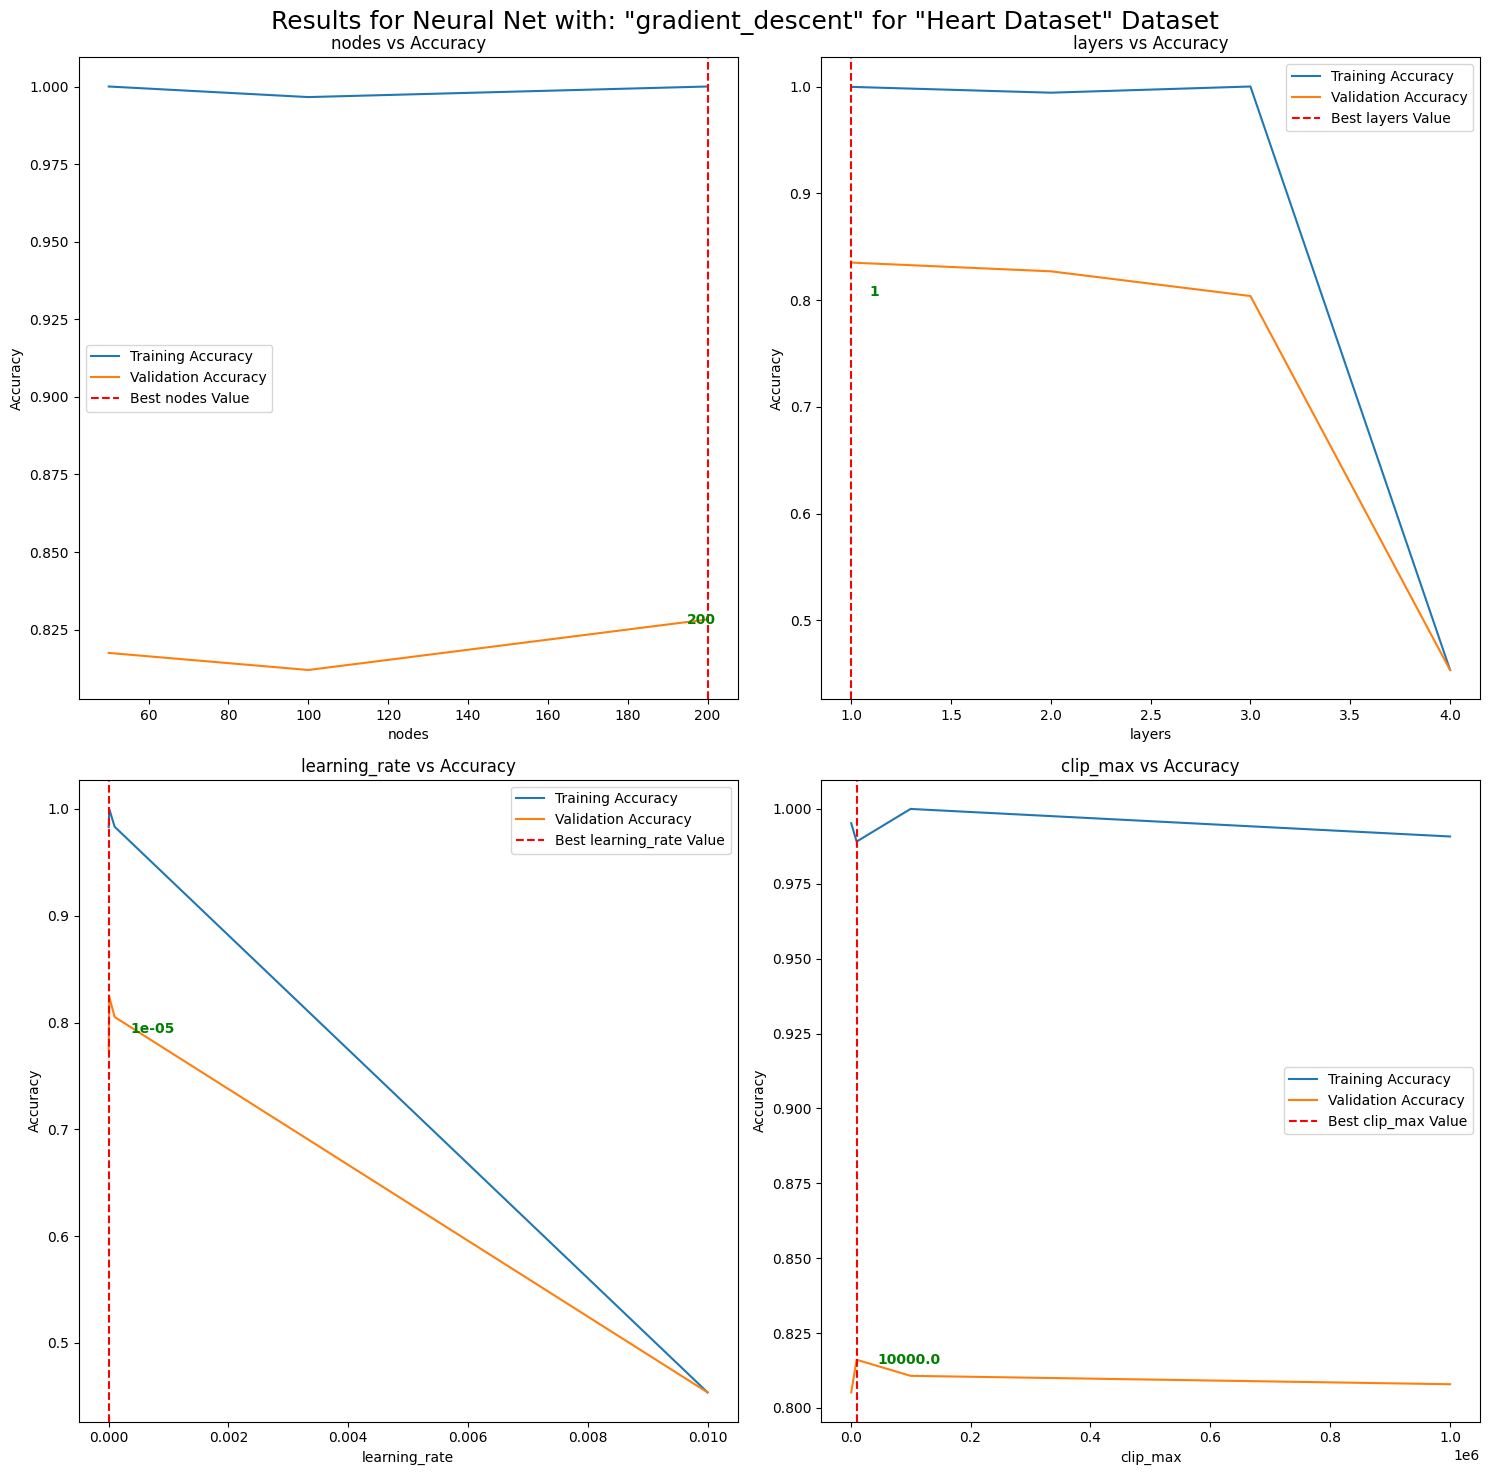

In [9]:
#Parameter dict for gradient descent
param_dict={
    'nodes':[50,100,200],
    'layers':[1,2,3,4],
    'learning_rate':[1e-6,1e-5,1e-4,1e-2],
    'clip_max':[1e3,1e4,1e5,1e6]
}

defaults_dict=deal_algorithm(train_standardized,param_dict,'Heart Dataset','gradient_descent')

In [73]:
#Running through the hyperparameteros for other dicts
best_dict={'max_attempts': 2,
 'max_iters': 10,
 'learning_rate': 1e-05,
 'clip_max': 10000.0,
 'nodes': 200,
 'layers': 1,
 'activation': 'relu',
 'algorithm':'genetic_alg',
 'curve': True,
 'early_stopping': True}

test=NeuralNetwork(**best_dict)

In [71]:
curve=test.fit(train_standardized[0],train_standardized[1])

In [55]:
curve

NeuralNetwork(clip_max=10000.0, curve=True, early_stopping=True, layers=1,
              learning_rate=1e-05, max_attempts=1, max_iters=10, nodes=200)

In [74]:
test.fitness_curve

[]

In [69]:
test.fitness_curve[:,0]

array([7.02212866, 7.02212866, 6.97302286, 6.6292823 , 6.6292823 ,
       6.6292823 , 6.6292823 , 5.30342584, 5.30342584, 5.30342584])

In [48]:
test.fitness_curve.shape[0]

10

In [52]:
test.fitness_curve

array([[ 8.61411958,  1.        ],
       [ 8.61411958,  2.        ],
       [ 8.61411958,  3.        ],
       [ 8.61411865,  5.        ],
       [ 8.61411845,  7.        ],
       [ 8.61411845,  8.        ],
       [ 8.61411774, 10.        ],
       [ 8.61411774, 11.        ],
       [ 8.61411714, 13.        ],
       [ 8.61411701, 15.        ]])

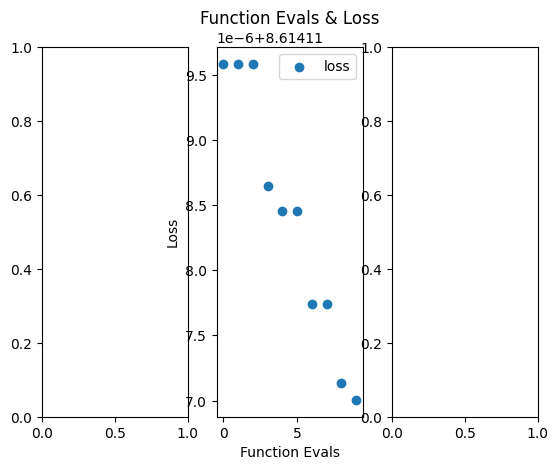

In [51]:
fig,axes=plt.subplots(1,3)
axes[-2].scatter(range(test.fitness_curve.shape[0]),test.fitness_curve[:,0],label='loss')
axes[-2].set_title('Function Evals & Loss')
axes[-2].set_xlabel('Function Evals')
axes[-2].set_ylabel('Loss')
axes[-2].legend()